**Testing Gradient_Boosting_Optimization.py**

In [55]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, random
import importlib
import numpy as np
from sklearn.metrics import make_scorer, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import Gradient_Boosting_Optimization
importlib.reload(Gradient_Boosting_Optimization) #Ensures file is uptodate!
from src.models.Gradient_Boosting_Optimization import Gradient_Boosting_Optimization

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [32]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape #Test

(1174, 21)

In [33]:
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
0,5.0,2.0,0.0,22877.0,0.0,6.0,0.400000,3.0,9.0,1939.0,0.0,12.190200
1,5.0,2.0,0.0,22967.0,0.0,6.0,0.400000,5.0,9.0,1939.0,0.0,12.190200
2,7.0,4.0,0.0,21293.0,0.0,6.0,0.571429,5.0,9.0,1939.0,0.0,14.434062


In [34]:
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [40]:
# Baseline ML_Class_1

print("Legacy (ML_Class_1.py) GB Test Results")

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import ML_Class_1
importlib.reload(ML_Class_1) #Ensures file is uptodate!
from src.models.ML_Class_1 import Model_Tester as LegacyTester

legacy = LegacyTester(
    model=GradientBoostingClassifier(random_state=1945),
    parameter_grid=None,
    cv_folds=5)

legacy.train_test_split(X, y, train_size=0.8, random_state=1945)
legacy.optimize()  #no grid search
legacy_results = legacy.evaluate(show_plots=False)
print("Legacy recall:", legacy_results["classification_report"]["1"]["recall"])


Legacy (ML_Class_1.py) GB Test Results

GradientBoostingClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       185
           1       0.71      0.44      0.54        50

    accuracy                           0.84       235
   macro avg       0.79      0.70      0.72       235
weighted avg       0.83      0.84      0.83       235


ROC AUC Score: 0.8351
Matthews Correlation Coefficient (MCC): 0.4733
Balanced Accuracy: 0.6957
GradientBoostingClassifier Confusion Matrix (values only):
[[176   9]
 [ 28  22]]
Legacy recall: 0.44


In [41]:
#Gradient_Boosting_Optimization, default GB (no grid or threshold) Used as a compairson to the Legacy tester
gb_default = Gradient_Boosting_Optimization(
    model=GradientBoostingClassifier(random_state=1945),
    parameter_grid=None,
    cv_folds=5,
    positive_label=1,
    optimize_scoring="recall",
    auto_calibrate_threshold=False)  #No threshold optimization


gb_default.train_test_split(X, y, train_size=0.8, random_state=1945)
gb_default.optimize()
gb_default_results = gb_default.evaluate(show_plots=False)


Applied decision threshold: 0.5000

GradientBoostingClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       185
           1       0.71      0.44      0.54        50

    accuracy                           0.84       235
   macro avg       0.79      0.70      0.72       235
weighted avg       0.83      0.84      0.83       235


ROC AUC Score: 0.8351
Matthews Correlation Coefficient (MCC): 0.4733
Balanced Accuracy: 0.6957
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          176            9
Actual 1           28           22
Recall (positive=1): 0.4400
F2 Score: 0.4762
False Negatives: 28


**Results for both are the same which indicates both are working as intended**

**Simple Optimization Tests:**

In [42]:
#Gradient_Boosting_Optimization, grid-search & F2 threshold optimization
gb_grid = Gradient_Boosting_Optimization(
    model=GradientBoostingClassifier(random_state=1945),
    parameter_grid = {
        "learning_rate": [0.05, 0.08, 0.1, 0.12, 0.15],
        "n_estimators": [300, 320, 340, 360, 380],
        "max_depth": [3, 4, 5],
        "min_samples_leaf": [1, 2, 3, 5],
        "min_samples_split": [2, 3, 5],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "max_features": ["sqrt", "log2", None],},
    cv_folds=5,
    positive_label=1,
    optimize_scoring="recall",
    auto_calibrate_threshold=True,
    threshold_beta=2.0)

gb_grid.train_test_split(X, y, train_size=0.8, random_state=1945)
gb_grid.optimize()
gb_grid_results = gb_grid.evaluate(show_plots=False)



Best Hyperparameters Found:
{'learning_rate': 0.12, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.7}
Best Cross-Validation Score: 0.4677
Applied decision threshold: 0.3930 (F-beta: 0.9930)

GradientBoostingClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       185
           1       0.62      0.58      0.60        50

    accuracy                           0.83       235
   macro avg       0.75      0.74      0.75       235
weighted avg       0.83      0.83      0.83       235


ROC AUC Score: 0.8248
Matthews Correlation Coefficient (MCC): 0.4939
Balanced Accuracy: 0.7414
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          167           18
Actual 1           21           29
Recall (positive=1): 0.5800
F2 Score: 0.5870
False Negatives: 21


In [44]:
print("Recall Compairsons: \n")
print("Baseline recall:", legacy_results["classification_report"]["1"]["recall"])
print("Default GB recall:", gb_default_results["classification_report"]["1"]["recall"])
print("Grid-search recall:", gb_grid_results["recall"])
# print("Grid search best params:", gb_grid.best_model.get_params())
# print("Grid search decision threshold:", gb_grid_results["decision_threshold"])

Recall Compairsons: 

Baseline recall: 0.44
Default GB recall: 0.44
Grid-search recall: 0.58


In [46]:
#Manual Threshold Comparison using gb_grid: 
thresholds = np.arange(0, 1.05, 0.05) 
thresholds = thresholds.tolist() 
rows = []

for t in thresholds:
    gb_grid.set_decision_threshold(t)
    res = gb_grid.evaluate(show_plots=False, print_results=False)
    rows.append({
        "threshold": t,
        "recall": res["recall"],
        "precision": res["classification_report"]["1"]["precision"],
        "false_negatives": res["false_negatives"],
        "accuracy": res["classification_report"]["accuracy"],
        "f1-scores": res["classification_report"]["macro avg"]["f1-score"]
        })
gb_grid.set_decision_threshold(None) 
threshold_results = pd.DataFrame(rows)
threshold_results

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

,threshold,recall,precision,false_negatives,accuracy,f1-scores
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,0.86,0.361345,7,0.646809,0.616564
2,0.10,0.80,0.449438,10,0.748936,0.698646
3,0.15,0.72,0.480000,14,0.774468,0.711188
4,0.20,0.68,0.523077,16,0.800000,0.729455
5,0.25,0.64,0.551724,18,0.812766,0.735523
6,0.30,0.64,0.592593,18,0.829787,0.753047
7,0.35,0.60,0.600000,20,0.829787,0.745946
8,0.40,0.54,0.600000,23,0.825532,0.729544
9,0.45,0.46,0.575000,27,0.812766,0.697661


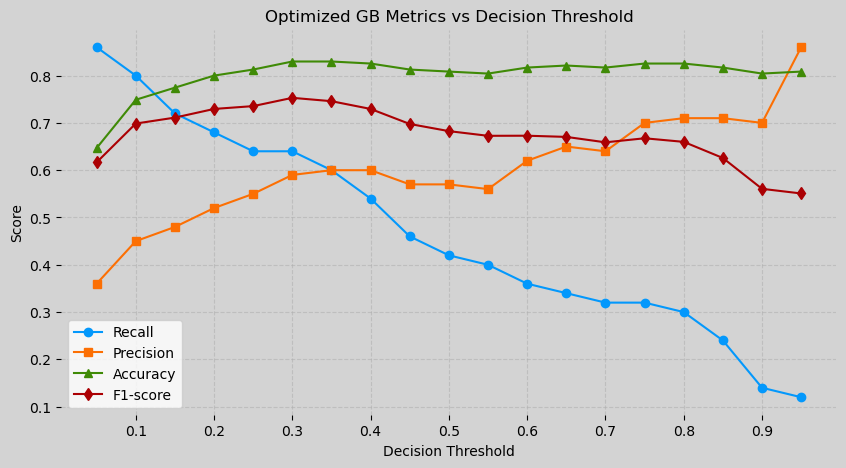

In [ ]:
#Results from above minus 0.00 and 1.00
data = {
    "threshold": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
                  0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95],
    "recall": [ 0.86, 0.80, 0.72, 0.68, 0.64, 0.64, 0.60, 0.54, 0.46,
               0.42, 0.40, 0.36, 0.34, 0.32, 0.32, 0.30, 0.24, 0.14, 0.12],
    "precision": [ 0.36, 0.45, 0.48, 0.52, 0.55, 0.59, 0.60, 0.60, 0.57,
                  0.57, 0.56, 0.62, 0.65, 0.64, 0.70, 0.71, 0.71, 0.70, 0.86],
    "accuracy": [ 0.6468, 0.7489, 0.7745, 0.8000, 0.8128, 0.8298, 0.8298,
                 0.8255, 0.8128, 0.8085, 0.8043, 0.8170, 0.8213, 0.8170, 0.8255,
                 0.8255, 0.8170, 0.8043, 0.8085],
    "f1": [ 0.6166, 0.6986, 0.7112, 0.7295, 0.7355, 0.7530, 0.7459,
            0.7295, 0.6977, 0.6826, 0.6727, 0.6729, 0.6704, 0.6589, 0.6675,
            0.6599, 0.6258, 0.5606, 0.5508,]}
df = pd.DataFrame(data)

#Plot Threshold Results:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.plot(df["threshold"], df["recall"], label="Recall", marker='o', color='#0398fc')
ax.plot(df["threshold"], df["precision"], label="Precision", marker='s', color='#fc6f03')
ax.plot(df["threshold"], df["accuracy"], label="Accuracy", marker='^', color='#3f8a06')
ax.plot(df["threshold"], df["f1"], label="F1-score", marker='d', color='#ab0003')
plt.title("Optimized GB Metrics vs Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()
# plt.tight_layout()
# plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/Optimized_GB_Threshold_Results')
plt.show()


In [36]:
res

{'model_name': 'XGBClassifier',
 'classification_report': {'0': {'precision': 0.7931034482758621,
   'recall': 0.9945945945945946,
   'f1-score': 0.882494004796163,
   'support': 185.0},
  '1': {'precision': 0.6666666666666666,
   'recall': 0.04,
   'f1-score': 0.07547169811320754,
   'support': 50.0},
  'accuracy': 0.7914893617021277,
  'macro avg': {'precision': 0.7298850574712643,
   'recall': 0.5172972972972973,
   'f1-score': 0.4789828514546853,
   'support': 235.0},
  'weighted avg': {'precision': 0.7662020053802885,
   'recall': 0.7914893617021277,
   'f1-score': 0.7107871310338321,
   'support': 235.0}},
 'confusion_matrix': array([[184,   1],
        [ 48,   2]]),
 'roc_auc': 0.8082162162162162,
 'mcc': 0.12611724994284856,
 'balanced_accuracy': 0.5172972972972973,
 'recall': 0.04,
 'f2_score': 0.04926108374384237,
 'decision_threshold': 0.9500000000000001,
 'threshold_metric': 0.8687782805427385,
 'false_negatives': 48}

**XGBoost Tests:**

In [69]:
#TODO Clean up and better optimize
from sklearn.model_selection import StratifiedKFold, train_test_split

xgb_params = {
    "eta": [0.03, 0.06],
    "max_depth": [3, 5],
    "min_child_weight": [1, 4],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "gamma": [0, 1],
    "reg_lambda": [1, 5],
    "scale_pos_weight": [1, 4],}

xgb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1945)

xgb_optimizer = Gradient_Boosting_Optimization(
    model=XGBClassifier(
        objective="binary:logistic",
        early_stopping_rounds=30,
        eval_metric="logloss",
        # use_label_encoder=False,
        random_state=1945,
        n_estimators=600,
        tree_method="hist",),

    parameter_grid=xgb_params,
    cv_folds=xgb_cv,
    positive_label=1,
    optimize_scoring="recall",
    auto_calibrate_threshold=True,
    threshold_beta=2.0,)

xgb_optimizer.train_test_split(X, y, train_size=0.8, random_state=1945)
_, X_valid_es, _, y_valid_es = train_test_split(
    xgb_optimizer.X_train,
    xgb_optimizer.y_train,
    test_size=0.2,
    stratify=xgb_optimizer.y_train,
    random_state=1945,)
fit_params = {
    "eval_set": [(X_valid_es, y_valid_es)],
    "verbose": False,}

xgb_optimizer.optimize(fit_params=fit_params)
xgb_results = xgb_optimizer.evaluate(show_plots=False)



Best Hyperparameters Found:
{'colsample_bytree': 0.7, 'eta': 0.03, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 4, 'reg_lambda': 5, 'scale_pos_weight': 4, 'subsample': 0.7}
Best Cross-Validation Score: 0.6668
Applied decision threshold: 0.4648 (F-beta: 0.8688)

XGBClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       185
           1       0.53      0.72      0.61        50

    accuracy                           0.80       235
   macro avg       0.72      0.77      0.74       235
weighted avg       0.83      0.80      0.81       235


ROC AUC Score: 0.8082
Matthews Correlation Coefficient (MCC): 0.4937
Balanced Accuracy: 0.7735
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          153           32
Actual 1           14           36
Recall (positive=1): 0.7200
F2 Score: 0.6716
False Negatives: 14


In [30]:
#Manual threshold comparison for the tuned XGBoost model
xgb_thresholds = np.arange(0.0, 1.0, 0.05).tolist()
baseline_threshold = xgb_optimizer.decision_threshold
xgb_rows = []

for t in xgb_thresholds:
    xgb_optimizer.set_decision_threshold(t)
    res = xgb_optimizer.evaluate(show_plots=False, print_results=False)
    xgb_rows.append({
        "threshold": t,
        "recall": res["recall"],
        "precision": res["classification_report"]["1"]["precision"],
        "false_negatives": res["false_negatives"],
        "accuracy": res["classification_report"]["accuracy"],
        "f1-score": res["classification_report"]["macro avg"]["f1-score"],
    })

xgb_optimizer.set_decision_threshold(baseline_threshold)
xgb_threshold_results = pd.DataFrame(xgb_rows)
xgb_threshold_results


/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

,threshold,recall,precision,false_negatives,accuracy,f1-score
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,0.98,0.219731,1,0.255319,0.235325
2,0.10,0.94,0.242268,3,0.361702,0.360765
3,0.15,0.88,0.261905,6,0.446809,0.443898
4,0.20,0.86,0.290541,7,0.523404,0.511289
5,0.25,0.86,0.328244,7,0.595745,0.573209
6,0.30,0.80,0.380952,10,0.680851,0.639017
7,0.35,0.76,0.413043,12,0.719149,0.666996
8,0.40,0.72,0.480000,14,0.774468,0.711188
9,0.45,0.72,0.514286,14,0.795745,0.731429


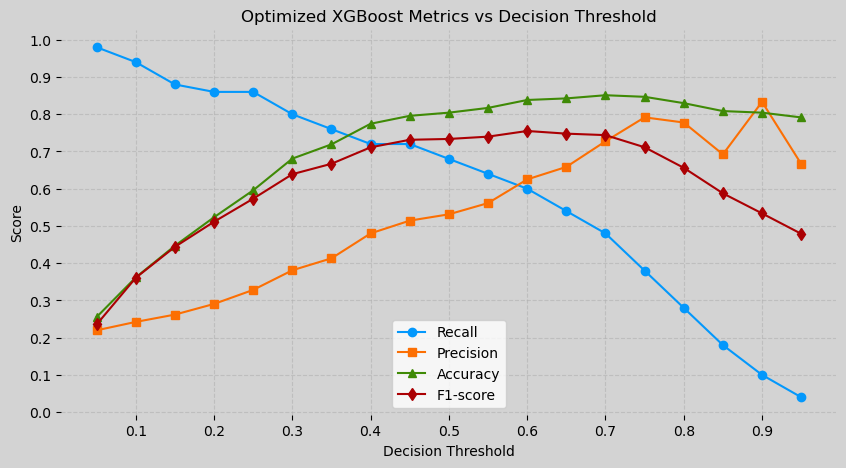

In [ ]:
#Results from above minus 0.00 and 1.00 (XGboost Optimized Model)
data = {
    "threshold": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
        0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95],
    "recall": [0.98, 0.94, 0.88, 0.86, 0.86, 0.80, 0.76, 0.72, 0.72,
        0.68, 0.64, 0.60, 0.54, 0.48, 0.38, 0.28, 0.18, 0.10, 0.04 ],
    "precision": [0.219731, 0.242268, 0.261905, 0.290541, 0.328244, 0.380952, 0.413043, 0.480000, 0.514286,
        0.531250, 0.561404, 0.625000, 0.658537, 0.727273, 0.791667, 0.777778, 0.692308, 0.833333, 0.666667],
    "false_negatives": [1, 3, 6, 7, 7, 10, 12, 14, 14, 16, 18, 20, 23, 26, 31, 36, 41, 45, 48],
    "accuracy": [0.255319, 0.361702, 0.446809, 0.523404, 0.595745, 0.680851, 0.719149, 0.774468, 0.795745,
        0.804255, 0.817021, 0.838298, 0.842553, 0.851064, 0.846809, 0.829787, 0.808511, 0.804255, 0.791489],
    "f1": [0.235325, 0.360765, 0.443898, 0.511289, 0.573209, 0.639017, 0.666996, 0.711188, 0.731429,
        0.733639, 0.739837, 0.755047, 0.747891, 0.743937, 0.711302, 0.656131, 0.587575, 0.533730, 0.478983]}
df = pd.DataFrame(data)

#Plot Threshold Results: (XGboost Model)
fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.plot(df["threshold"], df["recall"], label="Recall", marker='o', color='#0398fc')
ax.plot(df["threshold"], df["precision"], label="Precision", marker='s', color='#fc6f03')
ax.plot(df["threshold"], df["accuracy"], label="Accuracy", marker='^', color='#3f8a06')
ax.plot(df["threshold"], df["f1"], label="F1-score", marker='d', color='#ab0003')
plt.title("Optimized XGBoost Metrics vs Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend(loc=0) #Best location, not ideal here but center will have to do for now... 
# plt.tight_layout()
# plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/Optimized_XGBoost_Threshold_Results')
plt.show()
